In [11]:
## Training an image classifier

# 1. Loading and normalizing CIFAR10

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


horse horse truck  bird


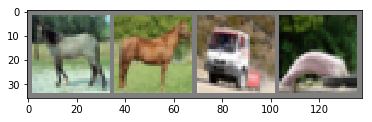

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
# 2. Define a Convolutional Neural Network

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [14]:
# 3. Define a Loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
# 4. Train the network

for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1,
                                           running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.144
[1,  4000] loss: 1.820
[1,  6000] loss: 1.686
[1,  8000] loss: 1.605
[1, 10000] loss: 1.533
[1, 12000] loss: 1.511
[2,  2000] loss: 1.447
[2,  4000] loss: 1.391
[2,  6000] loss: 1.410
[2,  8000] loss: 1.346
[2, 10000] loss: 1.343
[2, 12000] loss: 1.315
Finished Training


GroundTruth:    cat  ship  ship plane


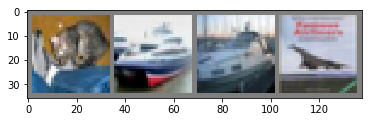

In [16]:
# 5. Test the network on the test data

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
outputs = net(images)

In [18]:
print(outputs)
_, predicted = torch.max(outputs, 1)

print('Predicted', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

tensor([[-1.0960, -2.0618,  1.7539,  3.3483,  0.1623,  3.0115,  0.7567,
         -0.6387, -0.6968, -2.9867],
        [ 4.8378,  4.1116, -1.6144, -2.3978, -1.6393, -4.3756, -4.5287,
         -3.6655,  6.9964,  3.0531],
        [ 2.8749,  3.0391, -1.0296, -1.3271, -1.2805, -2.7475, -2.6829,
         -2.4366,  3.9917,  2.4270],
        [ 4.6542,  0.3775,  0.7551, -1.7806,  0.2756, -2.9115, -3.1335,
         -2.4781,  3.7082,  0.5235]])
Predicted   cat  ship  ship plane


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 61 %
Accuracy of  bird : 29 %
Accuracy of   cat : 24 %
Accuracy of  deer : 44 %
Accuracy of   dog : 61 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 69 %
Accuracy of truck : 58 %


In [21]:
## Training on GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
print(torch.cuda.device_count())
net.to(device)

1


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
inputs, labels = inputs.to(device), labels.to(device)